**Train Random Forest Model**

1. import Python packages and training data

In [1]:
# adding required libraries
import pandas as pd
import numpy as np

In [2]:
# Load the data from csv
x_data_org =pd.read_csv('../data/interim/x_data_org.csv')
y_data_org =pd.read_csv('../data/interim/y_data_org.csv')
x_data_eda =pd.read_csv('../data/interim/x_data.csv')
y_data_eda =pd.read_csv('../data/interim/y_data.csv')
x_balanced_data =pd.read_csv('../data/interim/x_balanced_data.csv')
y_balanced_data =pd.read_csv('../data/interim/y_balanced_data.csv')

x_test_org =pd.read_csv('../data/interim/x_test_org.csv')
y_test_org =pd.read_csv('../data/interim/y_test_org.csv')
x_test_eda =pd.read_csv('../data/interim/x_test.csv')
y_test_eda =pd.read_csv('../data/interim/y_test.csv')
x_balanced_test =pd.read_csv('../data/interim/x_balanced_test.csv')
y_balanced_test =pd.read_csv('../data/interim/y_balanced_test.csv')

x_prediction =pd.read_csv('../data/raw/NBA_test.csv')

2. Train Extra Tree model

In [3]:
from sklearn.ensemble  import ExtraTreesClassifier
et_model = ExtraTreesClassifier(n_estimators=100, random_state=8)
et_model.fit(x_balanced_data, y_balanced_data.values.ravel())

ExtraTreesClassifier(random_state=8)

In [4]:
print(et_model.score(x_balanced_data, y_balanced_data))
print(et_model.score(x_balanced_test, y_balanced_test))

1.0
0.6035087719298246


5. Perform grid search for optimised parameters to increase accuracy

In [5]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_et = {
    'n_estimators': [100, 200, 500],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [4, 8, 16],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
et_model = ExtraTreesClassifier(random_state=8)

# Initialize GridSearchCV
grid_search_et = GridSearchCV(estimator=et_model, param_grid=param_grid_et, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_et.fit(x_balanced_data, y_balanced_data.values.ravel())

# Get the best parameters
best_params = grid_search_et.best_params_
print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}


In [37]:
# Train a new Random Forest model with the best parameters
et_model = ExtraTreesClassifier(**best_params, random_state=8)
et_model.fit(x_balanced_data, y_balanced_data.values.ravel())

ExtraTreesClassifier(max_depth=4, n_estimators=500, random_state=8)

5. Check feature importance

In [38]:
# get feature importance
threshold = 0.035
feature_importance = et_model.feature_importances_
important_features = x_balanced_data.columns[feature_importance >= threshold]
x_filtered = x_balanced_data[important_features]
# display the feature importance
print(important_features)

Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', 'FTM', 'FTA', 'OREB', 'DREB',
       'REB', 'TOV'],
      dtype='object')


In [39]:
et_model.fit(x_filtered, y_balanced_data.values.ravel())
print(et_model.score(x_balanced_data[important_features], y_balanced_data))
print(et_model.score(x_balanced_test[important_features], y_balanced_test))

0.6347673397717296
0.6421052631578947


6. Exam the model

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

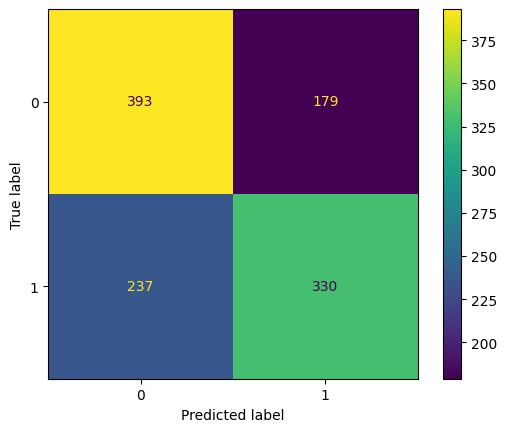

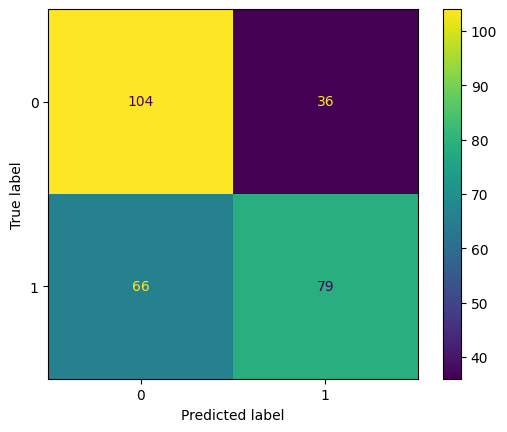

In [41]:
ConfusionMatrixDisplay.from_estimator(et_model, x_balanced_data[important_features], y_balanced_data)
ConfusionMatrixDisplay.from_estimator(et_model, x_balanced_test[important_features], y_balanced_test)

6. Conclusion
A bit under fitting,  this is a better model compare to SVM, Kmeans, Meanshift and Decision Tree models. 

7. Export Model and prediction

In [43]:
import joblib

# Export the Random Forest model
joblib.dump(et_model, '../models/et_model.pkl')

y_prediction = et_model.predict(x_prediction[important_features])

# Combine Id from x_prediction and y_prediction
prediction_results = pd.DataFrame({
    'Id': x_prediction['Id'],
    'TARGET_5Yrs': y_prediction
})

# Export the results to a CSV file
prediction_results.to_csv('../reports/prediction_results_etmodel.csv', index=False)